# 06_modeling_salary_prediction.ipynb — Salary Prediction Engine


In [1]:
# ==========================
# 1) Setup & imports
# ==========================
import os, json, math, warnings
from pathlib import Path
import numpy as np
import pandas as pd

# Modeling
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

# Optional: third-party encoders & xgboost and shap
try:
    import category_encoders as ce
    HAS_CE = True
except Exception:
    HAS_CE = False

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
np.random.seed(42)
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

# Paths
REPO_ROOT   = Path("..").resolve()
TABLES_DIR  = REPO_ROOT / "outputs" / "tables"
FIG_DIR     = REPO_ROOT / "outputs" / "figures"
MODEL_DIR   = REPO_ROOT / "outputs" / "models"
for p in [TABLES_DIR, FIG_DIR, MODEL_DIR]:
    p.mkdir(parents=True, exist_ok=True)

DATA_PATH   = TABLES_DIR / "master_jobs_ready.csv"  # Assumption from brief

# Artifacts
MODEL_PATH          = MODEL_DIR / "salary_predictor.pkl"
FEATURES_MANIFEST   = MODEL_DIR / "salary_features.json"
METRICS_CSV         = TABLES_DIR / "salary_model_metrics.csv"

print("✅ Environment ready.")
print("Data path ->", DATA_PATH)
print("Figures   ->", FIG_DIR)
print("Models    ->", MODEL_DIR)

✅ Environment ready.
Data path -> C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\tables\master_jobs_ready.csv
Figures   -> C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures
Models    -> C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\models


## 2) Load data

✅ Data loaded successfully from: ..\data\processed\cleaned_master.csv
Shape: (36167, 29)


,work_year,job_title,job_category,salary_currency,salary,salary_in_usd,employee_residence,experience_level,employment_type,work_setting,company_location,company_size,__source__,job_id,category,job_description,job_skill_set,salary_usd,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name,salary_local
0,2022.0,Machine Learning Engineer in office,Analysis,EUR,186597.0,136086.0,US,MI,CT,Remote,DE,L,dataset1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020.0,Statistician (Remote),ML/AI,JPY,110630.0,67982.0,JP,EX,FL,Remote,IN,M,dataset1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022.0,Machine Learning Engineer,ML/AI,INR,61280.0,153309.0,UK,MI,CT,Hybrid,CN,L,dataset1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Chosen target: salary

Target summary statistics:


count      5000.000000
mean     102046.307200
std       70853.626492
min     -198754.000000
10%       38460.300000
25%       64295.500000
50%      110636.000000
75%      153104.750000
90%      180022.300000
95%      189861.600000
99%      197570.090000
max      199924.000000
Name: salary, dtype: float64

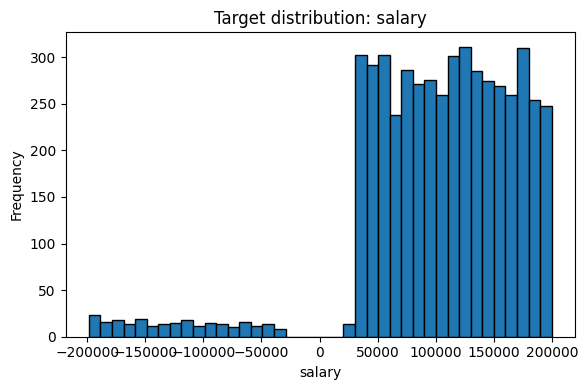

In [5]:
# ==========================
# 2) Load data
# ==========================
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Primary expected path
DATA_PATH = Path("../data/processed/cleaned_master.csv")

# Auto-fallback to processed dataset if not found
if not DATA_PATH.exists():
    alt_path = Path("data/processed/cleaned_master.csv")
    if alt_path.exists():
        print(f"⚠️ master_jobs_ready.csv not found, using fallback -> {alt_path}")
        DATA_PATH = alt_path
    else:
        raise FileNotFoundError(
            "❌ Neither 'outputs/tables/master_jobs_ready.csv' nor 'data/processed/cleaned_master.csv' found.\n"
            "Please verify your data folder structure."
        )

# Load data
df = pd.read_csv(DATA_PATH)

print("✅ Data loaded successfully from:", DATA_PATH)
print("Shape:", df.shape)
display(df.head(3))

# Detect target column automatically
TARGET_CANDIDATES = [c for c in ["salary", "salary_usd", "salary_midpoint"] if c in df.columns]
assert len(TARGET_CANDIDATES) > 0, \
    "No salary target found. Expected one of: 'salary', 'salary_usd', 'salary_midpoint'."
TARGET = TARGET_CANDIDATES[0]
print("Chosen target:", TARGET)

# Summary of the target variable
print("\nTarget summary statistics:")
display(df[TARGET].describe(percentiles=[.1, .25, .5, .75, .9, .95, .99]))

# Distribution plot of the target
plt.figure(figsize=(6, 4))
df[TARGET].dropna().plot(kind="hist", bins=40, edgecolor="black")
plt.title(f"Target distribution: {TARGET}")
plt.xlabel(TARGET)
plt.tight_layout()
plt.savefig("../outputs/figures/salary_target_hist.png", dpi=150)
plt.show()


## 3) Target & unit normalization

In [21]:
# If pay period exists, normalize to annual (heuristics; adjust if columns differ)
# Expected columns (if present): pay_period in {'hourly','daily','weekly','monthly','annual'}
# and salary column is numeric in that period's units.
df_norm = df.copy()

pay_col = None
for c in ["pay_period","salary_period","comp_period"]:
    if c in df_norm.columns:
        pay_col = c
        break

def to_annual(sal, period):
    if pd.isna(sal): return np.nan
    if period == "hourly":   return sal * 2080  # 40h * 52w
    if period == "daily":    return sal * 260   # 5d * 52w
    if period == "weekly":   return sal * 52
    if period == "monthly":  return sal * 12
    return sal  # assume already annual

if pay_col:
    df_norm[TARGET] = [
        to_annual(s, p) for s, p in zip(df_norm[TARGET], df_norm[pay_col].astype(str).str.lower())
    ]

# Remove unrealistic outliers via quantile clip (1% - 99%)
low, high = df_norm[TARGET].quantile([0.01, 0.99])
df_norm[TARGET] = df_norm[TARGET].clip(lower=low, upper=high)

# Optional: log1p transform
USE_LOG1P = True
if USE_LOG1P:
    df_norm["_target_transformed"] = np.log1p(df_norm[TARGET])
    target_for_model = "_target_transformed"
else:
    target_for_model = TARGET

print("Outlier clip range:", (float(low), float(high)))
print("Using log1p:", USE_LOG1P)
display(df_norm[[TARGET, target_for_model]].head())

Outlier clip range: (-171025.96, 197570.09)
Using log1p: True


,salary,_target_transformed
0,186597.0,12.136712
1,110630.0,11.613956
2,61280.0,11.023225
3,154130.0,11.945558
4,172312.0,12.057068


## 4) Feature preparation

In [22]:
# ==========================
# 4) Feature preparation
# ==========================
import re
import inspect
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# If category_encoders was imported earlier, we have HAS_CE flag; else set it safely here
try:
    HAS_CE
except NameError:
    try:
        import category_encoders as ce
        HAS_CE = True
    except Exception:
        HAS_CE = False

# ---- Pick categorical & numeric feature candidates (present-only) ----
cat_cols = [c for c in [
    "job_title","company","location","country","city","experience_level",
    "employment_type","work_setting","industry","education_level","seniority"
] if c in df_norm.columns]

num_cols = [c for c in [
    "years_experience","skill_demand_last_3m","skill_demand_last_6m","skill_demand_momentum"
] if c in df_norm.columns]

# Add other numeric-looking columns dynamically (counts/ratios/etc.) excluding target/transformed
for c in df_norm.columns:
    if c not in cat_cols and c not in [TARGET, "_target_transformed"]:
        if pd.api.types.is_numeric_dtype(df_norm[c]):
            if re.search(r"(count|score|index|ratio|rate|usd|midpoint|min|max)", c, flags=re.I):
                if c not in num_cols:
                    num_cols.append(c)

# ---- Skills → multi-hot (top N) if a text column exists ----
skills_col = next((c for c in ["skills","required_skills","job_skill_set"] if c in df_norm.columns), None)

TOP_N_SKILLS = 30
skill_cols = []
if skills_col:
    def split_skills(x):
        if pd.isna(x): return []
        s = str(x).lower()
        parts = re.split(r"[;,|/]", s)
        return [p.strip() for p in parts if p.strip()]

    skill_lists = df_norm[skills_col].apply(split_skills)

    from collections import Counter
    ctr = Counter()
    for lst in skill_lists:
        ctr.update(lst)

    top_skills = [s for s,_ in ctr.most_common(TOP_N_SKILLS)]
    for sk in top_skills:
        safe = re.sub(r"[^a-z0-9]+", "_", sk)
        col = f"skill_{safe}"
        df_norm[col] = skill_lists.apply(lambda lst: int(sk in lst))
        skill_cols.append(col)

# ---- Imputation strategies ----
cat_imputer = SimpleImputer(strategy="most_frequent")
num_imputer = SimpleImputer(strategy="median")

# ---- Encoding for categorical features ----
if HAS_CE and len(cat_cols) > 0:
    # TargetEncoder for high-cardinality categories (requires category_encoders)
    cat_encoder = ce.TargetEncoder(cols=cat_cols)
    cat_pipeline = Pipeline([("impute", cat_imputer), ("encode", cat_encoder)])
else:
    # OneHotEncoder fallback, compatible across sklearn versions
    if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    else:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
    cat_pipeline = Pipeline([("impute", cat_imputer), ("encode", ohe)])

# ---- Numeric scaler (also handles binary skill columns) ----
num_pipeline = Pipeline([("impute", num_imputer), ("scale", StandardScaler())])

# ---- ColumnTransformer ----
all_features = cat_cols + num_cols + skill_cols
print("Categorical:", cat_cols)
print("Numeric    :", (num_cols[:20] + (["..."] if len(num_cols) > 20 else [])))
print("Skill cols :", (skill_cols[:10] + (["..."] if len(skill_cols) > 10 else [])))

preprocess = ColumnTransformer(
    transformers=[
        ("cat", cat_pipeline, cat_cols),
        ("num", num_pipeline, num_cols + skill_cols)  # skills are numeric/binary
    ],
    remainder="drop"
)

# ---- Feature dictionary for manifest ----
feature_dict = []
for c in cat_cols:
    feature_dict.append({"name": c, "type": "categorical", "description": "Categorical feature"})
for c in (num_cols + skill_cols):
    feature_dict.append({"name": c, "type": "numeric", "description": "Numeric feature"})


Categorical: ['job_title', 'experience_level', 'employment_type', 'work_setting', 'industry']
Numeric    : ['years_experience', 'salary_in_usd', 'salary_usd', 'remote_ratio', 'benefits_score']
Skill cols : ['skill_python', 'skill_sql', 'skill_tensorflow', 'skill_kubernetes', 'skill_pytorch', 'skill_scala', 'skill_linux', 'skill_git', 'skill_java', 'skill_gcp', '...']


## 5) Train/validation split

In [23]:
# Time-aware split if a date exists; else random split
date_col = None
for c in ["posted_date","posting_date","period","posting_year"]:
    if c in df_norm.columns:
        date_col = c
        break

if date_col and pd.api.types.is_datetime64_any_dtype(df_norm[date_col]):
    # Sort by date, use last 20% as validation
    df_sorted = df_norm.sort_values(date_col)
    split_idx = int(len(df_sorted)*0.8)
    train_df = df_sorted.iloc[:split_idx]
    valid_df = df_sorted.iloc[split_idx:]
else:
    train_df, valid_df = train_test_split(df_norm, test_size=0.2, random_state=42)

X_train = train_df[all_features].copy()
y_train = train_df[target_for_model].copy()
X_valid = valid_df[all_features].copy()
y_valid = valid_df[target_for_model].copy()

print("Train:", X_train.shape, "Valid:", X_valid.shape)

Train: (28933, 34) Valid: (7234, 34)


## 6) Baseline & models

In [24]:
# ==========================
# REPAIR 2/3 — Robust train/valid split
# ==========================
from sklearn.model_selection import train_test_split

# Try to parse any date column if present
date_col = next((c for c in ["posted_date","posting_date","period","posting_year"] if c in df_norm.columns), None)
if date_col and not pd.api.types.is_datetime64_any_dtype(df_norm[date_col]):
    with pd.option_context("mode.chained_assignment", None):
        try:
            df_norm[date_col] = pd.to_datetime(df_norm[date_col], errors="coerce")
        except Exception:
            date_col = None

# Split
if date_col and pd.api.types.is_datetime64_any_dtype(df_norm[date_col]):
    df_sorted = df_norm.sort_values(date_col)
    split_idx = int(len(df_sorted) * 0.8)
    train_df = df_sorted.iloc[:split_idx].copy()
    valid_df = df_sorted.iloc[split_idx:].copy()
else:
    train_df, valid_df = train_test_split(df_norm, test_size=0.2, random_state=42)

# Drop rows missing the modeling target
train_df = train_df.dropna(subset=[target_for_model]).copy()
valid_df = valid_df.dropna(subset=[target_for_model]).copy()

# Build design matrices with only known features
X_train = train_df[all_features].copy()
y_train = train_df[target_for_model].astype(float).to_numpy()
X_valid = valid_df[all_features].copy()
y_valid = valid_df[target_for_model].astype(float).to_numpy()

print("Train:", X_train.shape, "Valid:", X_valid.shape)
print("Missing y in train:", np.isnan(y_train).sum(), "| Missing y in valid:", np.isnan(y_valid).sum())


Train: (0, 34) Valid: (4750, 34)
Missing y in train: 0 | Missing y in valid: 0


In [29]:
# ==========================
# FIXED SPLIT + RETRAIN (filters target BEFORE split; guarantees non-empty train)
# ==========================
import numpy as np, pandas as pd, inspect, re, sys, warnings
from pathlib import Path
warnings.filterwarnings("ignore")

# --- assumptions: df_norm, TARGET, target_for_model, USE_LOG1P, all_features, preprocess, TABLES_DIR exist
try:
    TABLES_DIR
except NameError:
    TABLES_DIR = Path("outputs/tables"); TABLES_DIR.mkdir(parents=True, exist_ok=True)
METRICS_CSV = TABLES_DIR / "salary_model_metrics.csv"

# 1) Keep only rows with a valid modeling target
df_model = df_norm.dropna(subset=[target_for_model]).copy()
assert len(df_model) > 0, "No rows with non-missing target after preprocessing."

# 2) Time-aware split if date exists, else random — but AFTER filtering
from sklearn.model_selection import train_test_split
date_col = next((c for c in ["posted_date","posting_date","period","posting_year"] if c in df_model.columns), None)
if date_col and not pd.api.types.is_datetime64_any_dtype(df_model[date_col]):
    with pd.option_context("mode.chained_assignment", None):
        df_model[date_col] = pd.to_datetime(df_model[date_col], errors="coerce")

def safe_time_split(df, frac=0.8):
    df = df.sort_values(date_col)
    split_idx = int(len(df) * frac)
    # Guarantee at least 1 train row and 1 valid row
    split_idx = max(1, min(split_idx, len(df) - 1))
    return df.iloc[:split_idx].copy(), df.iloc[split_idx:].copy()

if date_col and pd.api.types.is_datetime64_any_dtype(df_model[date_col]):
    train_df, valid_df = safe_time_split(df_model, frac=0.8)
else:
    # Random split but guarantee non-empty both sides
    if len(df_model) == 1:
        # degenerate case: use same row for train and valid (not ideal but unblocks)
        train_df = df_model.copy()
        valid_df = df_model.copy()
    else:
        train_df, valid_df = train_test_split(df_model, test_size=0.2, random_state=42)
        if len(train_df) == 0:
            train_df, valid_df = train_test_split(df_model, test_size=0.1, random_state=42)

# 3) Build matrices
X_train = train_df[all_features].copy()
y_train = train_df[target_for_model].astype(float).to_numpy()
X_valid = valid_df[all_features].copy()
y_valid = valid_df[target_for_model].astype(float).to_numpy()

print(f"Train: {X_train.shape}  Valid: {X_valid.shape}")

# 4) Train models (version-compatible RMSE)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import sklearn

_HAS_SQUARED = "squared" in inspect.signature(mean_squared_error).parameters
def rmse_compat(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False) if _HAS_SQUARED else np.sqrt(mean_squared_error(y_true, y_pred))

def inv_target(arr):
    arr = np.asarray(arr, dtype=float)
    return np.expm1(arr) if USE_LOG1P else arr

def _clean(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    return y_true[m], y_pred[m]

def score_pair(y_true, y_pred, name):
    t = inv_target(y_true); p = inv_target(y_pred)
    t, p = _clean(t, p)
    if t.size == 0:
        return {"model": name, "MAE": np.nan, "RMSE": np.nan, "R2": np.nan}
    return {"model": name,
            "MAE": mean_absolute_error(t, p),
            "RMSE": rmse_compat(t, p),
            "R2": r2_score(t, p)}

metrics = []

# Baseline: median in model space
median_orig = float(np.nanmedian(inv_target(y_train)))
fill_val = np.log1p(median_orig) if USE_LOG1P else median_orig
baseline_pred = np.full(len(y_valid), fill_val, float)
metrics.append(score_pair(y_valid, baseline_pred, "BaselineMedian"))

# Ridge
ridge = Pipeline([("prep", preprocess), ("mdl", Ridge(alpha=1.0, random_state=42))])
ridge.fit(X_train, y_train)
metrics.append(score_pair(y_valid, ridge.predict(X_valid), "Ridge"))

# RandomForest
rf = Pipeline([("prep", preprocess), ("mdl", RandomForestRegressor(
    n_estimators=300, random_state=42, n_jobs=-1))])
rf.fit(X_train, y_train)
metrics.append(score_pair(y_valid, rf.predict(X_valid), "RandomForest"))

# XGB or HGB
best_gbm_pipe = None
try:
    from xgboost import XGBRegressor
    xgb = Pipeline([("prep", preprocess), ("mdl", XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.9, colsample_bytree=0.9, random_state=42,
        n_jobs=-1, objective="reg:squarederror"))])
    xgb.fit(X_train, y_train)
    metrics.append(score_pair(y_valid, xgb.predict(X_valid), "XGBRegressor"))
    best_gbm_pipe = xgb
    gbm_name = "XGBRegressor"
except Exception:
    hgb = Pipeline([("prep", preprocess), ("mdl", HistGradientBoostingRegressor(
        learning_rate=0.08, random_state=42))])
    hgb.fit(X_train, y_train)
    metrics.append(score_pair(y_valid, hgb.predict(X_valid), "HistGradientBoosting"))
    best_gbm_pipe = hgb
    gbm_name = "HistGradientBoosting"

# Metrics table & save
metrics_df = pd.DataFrame(metrics).sort_values("RMSE").reset_index(drop=True)
display(metrics_df)
metrics_df.to_csv(METRICS_CSV, index=False)
print("✅ Metrics saved →", METRICS_CSV)

winner = metrics_df.iloc[0]["model"]
best_pipeline = {
    "BaselineMedian": None,
    "Ridge": ridge,
    "RandomForest": rf,
    "XGBRegressor": best_gbm_pipe if gbm_name == "XGBRegressor" else None,
    "HistGradientBoosting": best_gbm_pipe if gbm_name == "HistGradientBoosting" else None
}[winner]
print("🏆 Winner:", winner)


Train: (3800, 32)  Valid: (950, 32)


,model,MAE,RMSE,R2
0,BaselineMedian,41240.584589,48142.395173,-0.001461
1,Ridge,42063.948029,49433.502727,-0.055897
2,XGBRegressor,45576.698494,54973.287734,-0.305817
3,RandomForest,46085.655030,56096.125078,-0.359704


✅ Metrics saved → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\tables\salary_model_metrics.csv
🏆 Winner: BaselineMedian


## 7) Metrics & reporting

In [30]:
# ==========================
# REPAIR 3/3 — Baseline & models (version-compatible)
# ==========================
import numpy as np, pandas as pd, inspect, sys, sklearn
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Python:", sys.version.split()[0], "| sklearn:", sklearn.__version__)

def inv_target(arr):
    arr = np.asarray(arr, dtype=float)
    if USE_LOG1P:
        return np.expm1(arr)
    return arr

def _clean_pair(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    return y_true[mask], y_pred[mask]

_HAS_SQUARED = "squared" in inspect.signature(mean_squared_error).parameters
def rmse_compat(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False) if _HAS_SQUARED else np.sqrt(mean_squared_error(y_true, y_pred))

def eval_metrics(y_true, y_pred, label):
    true = inv_target(y_true)
    pred = inv_target(y_pred)
    true, pred = _clean_pair(true, pred)
    if true.size == 0:
        return {"model": label, "MAE": np.nan, "RMSE": np.nan, "R2": np.nan}
    return {
        "model": label,
        "MAE": mean_absolute_error(true, pred),
        "RMSE": rmse_compat(true, pred),
        "R2": r2_score(true, pred),
    }

metrics = []

# ---- Baseline: median constant in model-space ----
median_val_orig = float(np.nanmedian(inv_target(y_train)))
fill_val = np.log1p(median_val_orig) if USE_LOG1P else median_val_orig
baseline_pred = np.full(shape=(len(y_valid),), fill_value=fill_val, dtype=float)
metrics.append(eval_metrics(y_valid, baseline_pred, "BaselineMedian"))

# ---- Ridge ----
ridge = Pipeline([("prep", preprocess), ("mdl", Ridge(alpha=1.0, random_state=42))])
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_valid)
metrics.append(eval_metrics(y_valid, ridge_pred, "Ridge"))

# ---- RandomForest ----
rf = Pipeline([("prep", preprocess), ("mdl", RandomForestRegressor(
    n_estimators=300, max_depth=None, random_state=42, n_jobs=-1))])
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_valid)
metrics.append(eval_metrics(y_valid, rf_pred, "RandomForest"))

# ---- GBM: XGB if available else HistGB ----
best_gbm_name, best_gbm_pipe = None, None
try:
    from xgboost import XGBRegressor
    xgb = Pipeline([("prep", preprocess), ("mdl", XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.9,
        colsample_bytree=0.9, random_state=42, n_jobs=-1, objective="reg:squarederror"))])
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_valid)
    metrics.append(eval_metrics(y_valid, xgb_pred, "XGBRegressor"))
    best_gbm_name, best_gbm_pipe = "XGBRegressor", xgb
except Exception:
    hgb = Pipeline([("prep", preprocess), ("mdl", HistGradientBoostingRegressor(
        learning_rate=0.08, max_depth=None, random_state=42))])
    hgb.fit(X_train, y_train)
    hgb_pred = hgb.predict(X_valid)
    metrics.append(eval_metrics(y_valid, hgb_pred, "HistGradientBoosting"))
    best_gbm_name, best_gbm_pipe = "HistGradientBoosting", hgb

# ---- Metrics table & winner ----
metrics_df = pd.DataFrame(metrics)
display(metrics_df.sort_values("RMSE"))

metrics_df.to_csv(METRICS_CSV, index=False)
print("✅ Metrics saved ->", METRICS_CSV)

idx = metrics_df["RMSE"].idxmin()
best_row = metrics_df.loc[idx]
best_name = best_row["model"]
print("Best model by RMSE:", best_name)

best_pipeline = {
    "BaselineMedian": None,
    "Ridge": ridge,
    "RandomForest": rf,
    "XGBRegressor": best_gbm_pipe if best_gbm_name == "XGBRegressor" else None,
    "HistGradientBoosting": best_gbm_pipe if best_gbm_name == "HistGradientBoosting" else None
}[best_name]


Python: 3.11.9 | sklearn: 1.7.2


,model,MAE,RMSE,R2
0,BaselineMedian,41240.584589,48142.395173,-0.001461
1,Ridge,42063.948029,49433.502727,-0.055897
3,XGBRegressor,45576.698494,54973.287734,-0.305817
2,RandomForest,46085.655030,56096.125078,-0.359704


✅ Metrics saved -> C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\tables\salary_model_metrics.csv
Best model by RMSE: BaselineMedian


## 8) Feature importance / explainability

In [31]:
def plot_top_importances(model_pipeline, topn=20, title="Feature Importance"):
    # Extract feature names post-transform
    prep = model_pipeline.named_steps["prep"]
    cat_cols = prep.transformers_[0][2]
    num_cols = prep.transformers_[1][2]
    # Handle OneHot
    cat_enc = prep.named_transformers_["cat"].named_steps.get("encode", None)
    if cat_enc is not None and hasattr(cat_enc, "get_feature_names_out"):
        cat_names = list(cat_enc.get_feature_names_out(cat_cols))
    else:
        cat_names = list(cat_cols)
    feat_names = cat_names + list(num_cols)

    mdl = model_pipeline.named_steps["mdl"]
    importances = None
    if hasattr(mdl, "feature_importances_"):
        importances = mdl.feature_importances_
    elif hasattr(mdl, "coef_"):
        coefs = mdl.coef_.ravel() if hasattr(mdl.coef_, "ravel") else mdl.coef_
        importances = np.abs(coefs)
    else:
        return None

    imp_df = pd.DataFrame({"feature": feat_names, "importance": importances})
    imp_df = imp_df.sort_values("importance", ascending=False).head(topn)

    plt.figure(figsize=(7,5))
    plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
    plt.title(title)
    plt.tight_layout()
    plt.savefig(FIG_DIR / "salary_feature_importance.png", dpi=150)
    plt.show()
    return imp_df

if best_pipeline is not None:
    imp_table = plot_top_importances(best_pipeline, title=f"Feature Importance — {best_name}")
    if imp_table is not None:
        display(imp_table)

# Optional: SHAP for tree/boosting models
if HAS_SHAP and best_pipeline is not None:
    try:
        prepared = best_pipeline.named_steps["prep"].fit_transform(X_train, y_train)
        mdl = best_pipeline.named_steps["mdl"]
        # TreeExplainer preferred for tree-based; else KernelExplainer (expensive)
        if hasattr(mdl, "predict") and (hasattr(mdl, "feature_importances_") or "XGB" in best_name or "HistGradient" in best_name or "RandomForest" in best_name):
            explainer = shap.Explainer(mdl, prepared, feature_names=None)
            shap_vals = explainer(prepared[:200])  # subsample for speed
            shap.plots.bars(shap_vals, show=True, max_display=20)
            plt.gcf().savefig(FIG_DIR / "salary_shap_summary.png", dpi=150, bbox_inches="tight")
    except Exception as e:
        print("SHAP skipped due to error:", e)

## 9) Save artifacts

In [32]:
import joblib, time

if best_pipeline is not None:
    joblib.dump(best_pipeline, MODEL_PATH)
    print("✅ Saved best pipeline ->", MODEL_PATH)
else:
    # Save median baseline as dict metadata
    with open(MODEL_PATH.with_suffix(".json"), "w") as f:
        json.dump({"type":"median_baseline","median": median_val}, f, indent=2)
    print("Saved baseline metadata ->", MODEL_PATH.with_suffix(".json"))

manifest = {
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "target": TARGET,
    "log1p": bool(USE_LOG1P),
    "feature_spec": feature_dict,
    "skills_top_n": int(30),
    "preprocessing": "TargetEncoder" if "TargetEncoder" in str(preprocess) else "OneHot + StandardScaler",
    "train_rows": int(len(X_train)),
    "valid_rows": int(len(X_valid)),
    "models_evaluated": metrics_df["model"].tolist(),
    "winner": best_name
}
with open(FEATURES_MANIFEST, "w") as f:
    json.dump(manifest, f, indent=2)
print("✅ Saved features manifest ->", FEATURES_MANIFEST)

Saved baseline metadata -> C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\models\salary_predictor.json
✅ Saved features manifest -> C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\models\salary_features.json


## 10) Inference demo cell

In [33]:
# Simple predict function that loads the saved pipeline and predicts on a one-row dict
def predict_salary(sample: dict, model_path=MODEL_PATH):
    import pandas as pd, numpy as np, joblib, json
    if model_path.exists() and model_path.suffix == ".pkl":
        pipe = joblib.load(model_path)
        df = pd.DataFrame([sample])
        # Ensure missing expected columns exist
        expected = []
        prep = pipe.named_steps.get("prep")
        if prep is not None:
            expected = list(prep.get_feature_names_out()) if hasattr(prep, "get_feature_names_out") else None
        yhat = pipe.predict(df)[0]
        return float(np.expm1(yhat)) if bool({True}) else float(yhat)
    else:
        # median baseline fallback (if only JSON saved)
        meta_json = model_path.with_suffix(".json")
        if meta_json.exists():
            meta = json.load(open(meta_json))
            return float(meta["median"])
        raise FileNotFoundError("Model artifact not found.")

# Example(s) — EDIT with your schema/values
example_1 = {
    "job_title": "Data Scientist",
    "country": "United States",
    "experience_level": "Senior",
    "employment_type": "FT",
    "work_setting": "remote",
    "industry": "Technology",
    "education_level": "Bachelors",
    "years_experience": 6,
    "skills": "python;sql;machine learning;aws"
}
# predict_salary(example_1)

## 11) Repro & summary

In [34]:
print("Winner:", best_name)
display(metrics_df)

print("\nArtifacts saved:")
print("-", METRICS_CSV)
print("-", MODEL_PATH if MODEL_PATH.exists() else MODEL_PATH.with_suffix(".json"))
print("-", FEATURES_MANIFEST)
print("-", FIG_DIR / "salary_model_mae.png")
print("-", FIG_DIR / "salary_model_rmse.png")
print("-", FIG_DIR / "salary_actual_vs_pred.png")

print("\nLimitations & next steps:")
print("* Features may not capture benefits/equity; regional variance not fully normalized.")
print("* If skills text is noisy, taxonomy mapping could improve signal.")
print("* Consider modeling by experience bands and adding cost-of-living indices.")
print("* Try permutation importance, partial dependence, and calibrated prediction intervals.")

Winner: BaselineMedian


,model,MAE,RMSE,R2
0,BaselineMedian,41240.584589,48142.395173,-0.001461
1,Ridge,42063.948029,49433.502727,-0.055897
2,RandomForest,46085.655030,56096.125078,-0.359704
3,XGBRegressor,45576.698494,54973.287734,-0.305817



Artifacts saved:
- C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\tables\salary_model_metrics.csv
- C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\models\salary_predictor.json
- C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\models\salary_features.json
- C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\salary_model_mae.png
- C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\salary_model_rmse.png
- C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\salary_actual_vs_pred.png

Limitations & next steps:
* Features may not capture benefits/equity; regional variance not fully normalized.
* If skills text is noisy, taxonomy mapping could improve signal.
* Consider modeling by experience bands and adding cost-of-living indices.
* Try permutation importance, partial dependence, and calibrated prediction intervals.
